In [1]:
# Interpretation of trackers

# real_baseline_trackers has two lists for adversarial token per sample
# The first list shows the rank and probability assigned to the ground truth label in the benign setting
# The second list shows the rank and probability assigned to the true label in the adversarial setting

# template_baseline_trackers has two lists for adversarial token per sample
# The first list shows the rank and probability assigned to the ground truth label in the benign setting with the template phrase
# The second list shows the rank and probability assigned to the true label in the adversarial setting

# adversarial trackers has three lists for adversarial token per sample
# The first list shows the rank and probability assigned to the adversarial label in the benign setting with the template phrase
# The second list shows the rank and probability assigned to the adversarial label under the benign setting with the template phrase
# The third list shows the rank and probability assigned to the adversarial label under the adversarial setting
# Possible questions we can answer from this data

# 1 - How sparse/dense is the embedding space around the gradient vector? We are choosing the top-k tokens around the gradient vector as candidate adversarial tokens but perhaps the embedding space is so sparse (due to high dimensionality) that these vectors are not meaningfully close as defined by a metric like cosine distance
    # I am not exactly sure what would be a threshold for sparseness or the what constitutes closess or the lack of it in the embedding space so fairly open
    # Perhaps relative distances/sparsesness b/w the samples could be useful

# 2 - Is there a correlation b/w adversarialness of the token (in terms of reducing the prob. of the ground true token or increasing prob of adversarial token) and the distance of the adversarial token to the gradient vector.
    # Since we are approximating the gradient, it would make some sense that only the tokens with embeddings close to the gradient vector are adversarial and not every random vector
    # Maybe it is mostly random vectors that are adversarial. If that is the case, would be interesting to know.

# 3 - What is the relationship between the adversarial token and the incorrectly predicted [MASK] token? 
    # More open ended and open to exploratory analysis
    # One approach would be to compute cosine distance b/w the adv. token and the new incorrectly predicted token's embeddings

# If you think there are other interesting things we can find in this data, please do explore them. If you need any more data, let me know I probably have that saved up and can format it quickly.


# Need to analyze and compare baseline true label probability / loss in succesful and unsuccessful examples


# Comparison b/w succ and unsucc examples
  # - Is model more confident about resilient examples than brittle examples?
  # - Are there just not enough adv tokens in the embedding space for resilient examples such that you can't approximate th gradient vector accurately? IOW ~ Is that what makes the example resilient?
  

In [2]:
%set_env TRANSFORMERS_CACHE=/bigstor/zsarwar/models/cache
%set_env CUDA_VISIBLE_DEVICES=0

env: TRANSFORMERS_CACHE=/bigstor/zsarwar/models/cache
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoTokenizer, AutoModelWithLMHead, AutoModelForMaskedLM
import torch.nn.functional as F
import torch
from scipy.stats import entropy
import sys
from scipy.spatial.distance import cosine



/home/zsarwar/.conda/envs/nlp2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(precision=10)
torch.set_printoptions(threshold=sys.maxsize)

In [5]:
# Load model and embeddings
def load_pretrained(model_name):
    """
    Loads pretrained HuggingFace config/model/tokenizer, as well as performs required
    initialization steps to facilitate working with triggers.
    """
    config = AutoConfig.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_pretrained(model_name)
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
    return config, model, tokenizer

def get_embeddings(model, config):
    base_model = getattr(model, config.model_type)
    word_embeddings = base_model.embeddings.word_embeddings
    #positional_embeddings = base_model.embeddings.position_embeddings
    #segment_embeddings = base_model.embeddings.token_type_embeddings

    return word_embeddings
    #return word_embeddings, positional_embeddings, segment_embeddings

config, model, tokenizer = load_pretrained('bert-large-cased')
model.to(device)
embeddings = get_embeddings(model, config)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# For each successful example, load the following:
    # Gradient, top-100 adv tokens, true label, adv label and their probabiltiies
    

In [7]:
def cosine_sim(grad, tokens):
    dot = np.dot(tokens, grad).reshape(-1)
    norms = np.multiply(np.linalg.norm(grad) , np.linalg.norm(tokens, axis=1)).reshape(-1)
    sim = np.divide(dot, norms)
    return sim


def cos_sim_row_wise(labels, tokens):
    dot = np.sum(labels * tokens, axis=1)    
    labels_norm = np.linalg.norm(labels, axis=1)
    tokens_norm = np.linalg.norm(tokens, axis=1)
    den = np.multiply(labels_norm, tokens_norm)
    sim = np.divide(dot, den)
    return sim

In [8]:
all_numpy = ["/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_0_end_idx_1000_filter_false.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_1000_end_idx_2000_filter_false.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_2000_end_idx_3000_filter_false.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_3000_end_idx_4000_filter_false.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_4000_end_idx_5000_filter_false.npy"]

In [9]:
# From the entire data, this part extracts the samples for which at least one token (among the 100 candidate tokens) was successful in flipping the prediction of the [MASK] token
all_adversarial_trackers = []
all_real_baseline_trackers = []
all_template_baseline_trackers = []
all_gradient_vectors = []
all_candidate_tokens = []
all_true_labels = []
all_adv_labels = []
all_fail_indices = []
all_success_masks = []


In [10]:
trigger_type="template_hotword"
real_baseline = 'real_base'
template_baseline = 'template_base'
adversarial = 'adversarial'
SETTING = "no_filter_top_100"

# Dont run this cell again!

In [11]:
for numpy_file in all_numpy:
    loaded_dict = np.load(numpy_file, allow_pickle=True)
    loaded_dict = loaded_dict.item()
    for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
        first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
        if (first_succ_rank != -100):
            true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i]
            adv_labels = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i]
            succ_mask = [False if a_lab == true_label else True for a_lab in adv_labels]
            real_tracker = loaded_dict["results_baseline_real"]['base_real_rank_prob_tracker'][i]
            template_tracker = loaded_dict["results_baseline_template"]['base_template_rank_prob_tracker'][i]
            adv_tracker = loaded_dict["results_adversarial"]['adv_rank_prob_tracker'][i]
            gradient = loaded_dict["results_adversarial"]['all_gradient_vectors'][i]
            candidates = loaded_dict["results_adversarial"]['all_adv_tokens'][i]    
            all_real_baseline_trackers.append(real_tracker)
            all_template_baseline_trackers.append(template_tracker)
            all_adversarial_trackers.append(adv_tracker)
            all_true_labels.append(true_label)
            all_adv_labels.append(adv_labels)
            all_success_masks.append(succ_mask)
            all_gradient_vectors.append(gradient)
            all_candidate_tokens.append(candidates)
        else:
            all_fail_indices.append(i)


In [ ]:
s_adversarial_trackers = []
s_real_baseline_trackers = []
s_template_baseline_trackers = []
s_candidate_tokens = []
s_adv_labels = []
s_gradient_vectors = []
s_true_labels = []

for i in range(len(all_gradient_vectors)):
    t_adv_tracker = [all_adversarial_trackers[i][j] for j in range(len(all_adversarial_trackers[i])) if all_success_masks[i][j] == True]
    t_real_baseline_tracker = [all_real_baseline_trackers[i][j] for j in range(len(all_real_baseline_trackers[i])) if all_success_masks[i][j] == True]
    t_template_baseline_tracker = [all_template_baseline_trackers[i][j] for j in range(len(all_template_baseline_trackers[i])) if all_success_masks[i][j] == True]
    t_cand_tokens =  [all_candidate_tokens[i][j] for j in range(len(all_candidate_tokens[i])) if all_success_masks[i][j] == True]
    t_cand_tokens = [tok.item() for tok in t_cand_tokens]    
    t_adv_labels = [all_adv_labels[i][j] for j in range(len(all_adv_labels[i])) if all_success_masks[i][j] == True]
    t_adv_labels = [label.item() for label in t_adv_labels]
    s_adversarial_trackers.append(t_adv_tracker)
    s_real_baseline_trackers.append(t_real_baseline_tracker)
    s_template_baseline_trackers.append(t_template_baseline_tracker)
    s_candidate_tokens.append(t_cand_tokens)
    s_adv_labels.append(t_adv_labels)
    s_gradient_vectors.append(all_gradient_vectors[i])
    s_true_labels.append(all_true_labels[i])


    


In [ ]:
# Embedding distances
# Compute mean cosine dist. for all successful tokens in one example and visualize distribution
s_cosine_sim = []

for i in range(len(s_adv_labels)):
    tokens = embeddings.weight[s_candidate_tokens[i]].cpu().detach().numpy()
    grad = s_gradient_vectors[i].cpu().numpy().T
    cos_sim = cosine_sim(grad, tokens)
    s_cosine_sim.append(cos_sim)

In [ ]:
s_cosine_sim = np.asarray(s_cosine_sim, dtype=object)
s_mean_cosine_sim = np.asarray([np.mean(arr) for arr in s_cosine_sim])
s_std_cosine_sim = np.asarray([np.std(arr) for arr in s_cosine_sim])


In [16]:
total_s_subsamples = sum(len(cos) for cos in s_cosine_sim)

In [ ]:
u_adversarial_trackers = []
u_real_baseline_trackers = []
u_template_baseline_trackers = []
u_candidate_tokens = []
u_adv_labels = []
u_true_labels = []
u_adv_labels = []
u_gradient_vectors = []
idx_no_fails = []

for i in range(len(all_gradient_vectors)):
    t_adv_tracker = [all_adversarial_trackers[i][j] for j in range(len(all_adversarial_trackers[i])) if all_success_masks[i][j] == False]
    t_real_baseline_tracker = [all_real_baseline_trackers[i][j] for j in range(len(all_real_baseline_trackers[i])) if all_success_masks[i][j] == False]
    t_template_baseline_tracker = [all_template_baseline_trackers[i][j] for j in range(len(all_template_baseline_trackers[i])) if all_success_masks[i][j] == False]
    t_cand_tokens =  [all_candidate_tokens[i][j] for j in range(len(all_candidate_tokens[i])) if all_success_masks[i][j] == False]
    t_cand_tokens = [tok.item() for tok in t_cand_tokens]    
    t_adv_labels = [all_adv_labels[i][j] for j in range(len(all_adv_labels[i])) if all_success_masks[i][j] == False]
    
    if(len(t_adv_tracker) == 0):
        idx_no_fails.append(i)
        continue
    t_adv_labels = [label.item() for label in t_adv_labels]
    u_adversarial_trackers.append(t_adv_tracker)
    u_real_baseline_trackers.append(t_real_baseline_tracker)
    u_template_baseline_trackers.append(t_template_baseline_tracker)
    u_candidate_tokens.append(t_cand_tokens)
    u_adv_labels.append(t_adv_labels)    
    u_gradient_vectors.append(all_gradient_vectors[i])
    u_true_labels.append(all_true_labels[i])


In [ ]:
# Embedding distances
# Compute mean cosine dist. for all successful tokens in one example and visualize distribution
u_cosine_sim = []
for i in range(len(u_adv_labels)):
    tokens = embeddings.weight[u_candidate_tokens[i]].cpu().detach().numpy()
    grad = u_gradient_vectors[i].cpu().numpy().T
    cos_sim = cosine_sim(grad, tokens)
    u_cosine_sim.append(cos_sim)

In [ ]:
u_cosine_sim = np.asarray(u_cosine_sim, dtype=object)
u_mean_cosine_sim = np.asarray([np.mean(arr) for arr in u_cosine_sim] )
u_std_cosine_sim = np.asarray([np.std(arr) for arr in u_cosine_sim])

In [ ]:
total_u_subsamples = sum(len(cos) for cos in u_cosine_sim)

# Scatterplots for mean cosine sims b/w benign and adversarial samples

In [ ]:
s_mean_cosine_sim_filtered = np.delete(s_mean_cosine_sim, idx_no_fails, 0)

In [ ]:
df_s_u_means = pd.DataFrame([s_mean_cosine_sim_filtered, u_mean_cosine_sim]).T
df_s_u_means.columns = ['Mean sim. for adversarial tokens', 'Mean sim. for benign tokens']

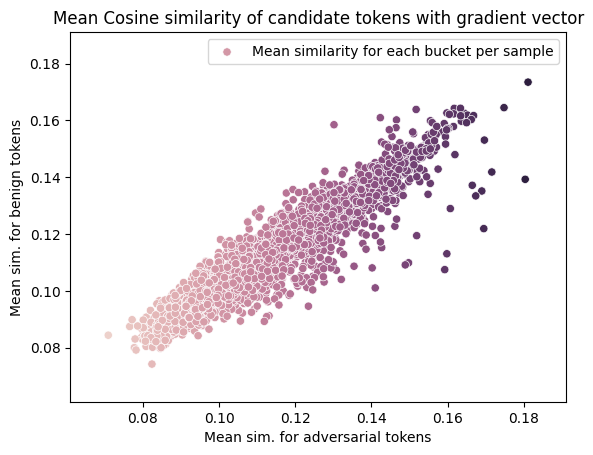

In [26]:
g = sns.scatterplot(data=df_s_u_means, x=df_s_u_means.columns[0], y=df_s_u_means.columns[1], hue=df_s_u_means.columns[0])
plt.title("Mean Cosine similarity of candidate tokens with gradient vector")
plt.legend(labels=["Mean similarity for each bucket per sample"])
fig = g.get_figure()

# Compute Min and Max across both and set as limits
min = df_s_u_means.min().min()
max = df_s_u_means.max().max()


g.set_xlim(min - 0.01,max + 0.01)
g.set_ylim(min - 0.01,max+ 0.01)
plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/scatter_mean_cosine_sim_{template_baseline}_{adversarial}_{SETTING}.jpg", dpi=500)

# Computing distance in input embedding space between adversarial tokens and predicted tokens

In [27]:
u_adv_labels = np.asarray([np.asarray(arr) for arr in u_adv_labels], dtype=object)
u_candidate_tokens = np.asarray([np.asarray(arr) for arr in u_candidate_tokens], dtype=object)

s_adv_labels = np.asarray([np.asarray(arr) for arr in s_adv_labels], dtype=object)
s_candidate_tokens = np.asarray([np.asarray(arr) for arr in s_candidate_tokens], dtype=object)

In [28]:
# Successful examples
s_label_adv_token_cos_sim = []

for i in range(len(s_adv_labels)):
    adv_label_embs = embeddings.weight[s_adv_labels[i]].cpu().detach().numpy()
    adv_token_embs = embeddings.weight[s_candidate_tokens[i]].cpu().detach().numpy()
    cos_sim = cos_sim_row_wise(adv_label_embs, adv_token_embs)
    s_label_adv_token_cos_sim.append(cos_sim)
    

In [29]:
# Unsuccessful examples
u_label_adv_token_cos_sim = []

for i in range(len(u_adv_labels)):
    adv_label_embs = embeddings.weight[u_adv_labels[i]].cpu().detach().numpy()
    adv_token_embs = embeddings.weight[u_candidate_tokens[i]].cpu().detach().numpy()
    cos_sim = cos_sim_row_wise(adv_label_embs, adv_token_embs)
    u_label_adv_token_cos_sim.append(cos_sim)
    

In [30]:
s_label_adv_token_cos_sim = np.asarray(s_label_adv_token_cos_sim, dtype=object)
s_mean_label_adv_token_cos_sim = np.asarray([np.mean(arr) for arr in s_label_adv_token_cos_sim])
s_std_label_adv_token_cos_sim = np.asarray([np.std(arr) for arr in s_label_adv_token_cos_sim])


u_label_adv_token_cos_sim = np.asarray(u_label_adv_token_cos_sim, dtype=object)
u_mean_label_adv_token_cos_sim = np.asarray([np.mean(arr) for arr in u_label_adv_token_cos_sim] )
u_std_label_adv_token_cos_sim = np.asarray([np.std(arr) for arr in u_label_adv_token_cos_sim])

In [31]:
s_mean_label_adv_token_cos_sim_filtered = np.delete(s_mean_label_adv_token_cos_sim, idx_no_fails, 0)

In [32]:
np.mean(u_mean_label_adv_token_cos_sim)

0.085902244

In [33]:
np.std(u_mean_label_adv_token_cos_sim)

0.054712344

In [34]:
sum(len(samples) for samples in s_label_adv_token_cos_sim)

156417

In [35]:
df_u_s_mean_label_adv_token_cos_sim = pd.DataFrame([s_mean_label_adv_token_cos_sim_filtered, u_mean_label_adv_token_cos_sim ]).T
df_u_s_mean_label_adv_token_cos_sim.columns = ["Mean sim. b/w predicted and adversarial tokens", "Mean sim. b/w predicted and benign tokens"]

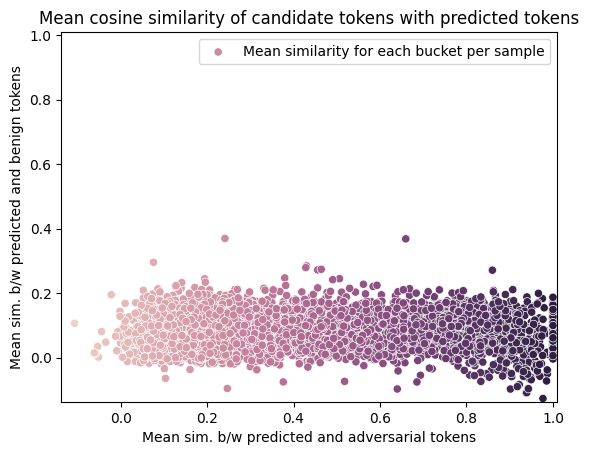

In [36]:
# Scatterplots

g = sns.scatterplot(data=df_u_s_mean_label_adv_token_cos_sim, x=df_u_s_mean_label_adv_token_cos_sim.columns[0], y=df_u_s_mean_label_adv_token_cos_sim.columns[1], hue=df_u_s_mean_label_adv_token_cos_sim.columns[0])
plt.title("Mean cosine similarity of candidate tokens with predicted tokens")
plt.legend(labels=["Mean similarity for each bucket per sample"])
fig = g.get_figure()

# Compute Min and Max across both and set as limits
min = df_u_s_mean_label_adv_token_cos_sim.min().min()
max = df_u_s_mean_label_adv_token_cos_sim.max().max()
g.set_xlim(min - 0.01,max + 0.01)
g.set_ylim(min - 0.01,max+ 0.01)
plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/scatter_mean_cosine_sim_pred_label_trigger_token_{template_baseline}_{adversarial}_{SETTING}.jpg", dpi=500)

In [74]:
# Check if in any case the prob. of the adv label is higher in the s_adv


In [81]:
u_adversarial_trackers[0][0]

[((tensor([0]),), tensor([0.2579349279])),
 ((tensor([0]),), tensor([0.0308004450])),
 ((tensor([0]),), tensor([0.0402456261]))]

# No samples where model cheats by using the trigger token as the predicted token

In [37]:
# Same thing but filter out samples where trigg token is also the predicted token
# Remove idx_no_fails
s_adv_labels_filtered = np.delete(s_adv_labels, idx_no_fails, axis=0)
s_candidate_tokens_filtered = np.delete(s_candidate_tokens, idx_no_fails, axis=0)

In [38]:
s_cheat_indices = [np.where(s_adv_labels_filtered[i] == s_candidate_tokens_filtered[i])  for i in range(len(s_adv_labels_filtered))]

In [39]:
s_adv_labels_filtered = np.asarray([np.delete(s_adv_labels_filtered[i], s_cheat_indices[i][0], axis=0)   for i in range(len(s_cheat_indices))], dtype=object)
s_candidate_tokens_filtered = np.asarray([np.delete(s_candidate_tokens_filtered[i], s_cheat_indices[i][0], axis=0)   for i in range(len(s_cheat_indices))], dtype=object)

In [40]:
# Index and remove instances with no remaining inputs

s_empty_lists_idx = [i for i in range(len(s_adv_labels_filtered)) if len(s_adv_labels_filtered[i]) == 0]


In [41]:

s_adv_labels = np.delete(s_adv_labels_filtered, s_empty_lists_idx,  axis=0)
s_candidate_tokens = np.delete(s_candidate_tokens_filtered, s_empty_lists_idx,  axis=0)

# Also remove filter u array on this list to make 1-1 comparison successsful
u_adv_labels = np.delete(u_adv_labels, s_empty_lists_idx,  axis=0)
u_candidate_tokens = np.delete(u_candidate_tokens, s_empty_lists_idx,  axis=0)




In [42]:
# Successful examples
s_label_adv_token_cos_sim = []

for i in range(len(s_adv_labels)):
    adv_label_embs = embeddings.weight[s_adv_labels[i]].cpu().detach().numpy()
    adv_token_embs = embeddings.weight[s_candidate_tokens[i]].cpu().detach().numpy()
    cos_sim = cos_sim_row_wise(adv_label_embs, adv_token_embs)
    s_label_adv_token_cos_sim.append(cos_sim)
    

In [43]:
# Unsuccessful examples
u_label_adv_token_cos_sim = []

for i in range(len(u_adv_labels)):
    adv_label_embs = embeddings.weight[u_adv_labels[i]].cpu().detach().numpy()
    adv_token_embs = embeddings.weight[u_candidate_tokens[i]].cpu().detach().numpy()
    cos_sim = cos_sim_row_wise(adv_label_embs, adv_token_embs)
    u_label_adv_token_cos_sim.append(cos_sim)
    

In [44]:
s_label_adv_token_cos_sim = np.asarray(s_label_adv_token_cos_sim, dtype=object)
s_mean_label_adv_token_cos_sim = np.asarray([np.mean(arr) for arr in s_label_adv_token_cos_sim])
s_std_label_adv_token_cos_sim = np.asarray([np.std(arr) for arr in s_label_adv_token_cos_sim])


u_label_adv_token_cos_sim = np.asarray(u_label_adv_token_cos_sim, dtype=object)
u_mean_label_adv_token_cos_sim = np.asarray([np.mean(arr) for arr in u_label_adv_token_cos_sim] )
u_std_label_adv_token_cos_sim = np.asarray([np.std(arr) for arr in u_label_adv_token_cos_sim])

In [45]:
sum(len(samples) for samples in s_label_adv_token_cos_sim)

99540

In [46]:
np.mean(u_mean_label_adv_token_cos_sim)

0.08565507

In [47]:
df_u_s_mean_label_adv_token_cos_sim = pd.DataFrame([s_mean_label_adv_token_cos_sim, u_mean_label_adv_token_cos_sim]).T
df_u_s_mean_label_adv_token_cos_sim.columns = ["Mean sim. b/w predicted and adversarial tokens", "Mean sim. b/w predicted and benign tokens"]

In [48]:
SETTING = SETTING + "_no_cheats_"

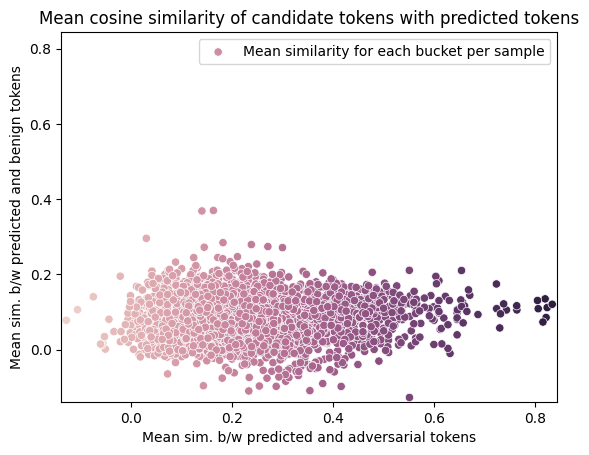

In [51]:
# Scatterplots

g = sns.scatterplot(data=df_u_s_mean_label_adv_token_cos_sim, x=df_u_s_mean_label_adv_token_cos_sim.columns[0], y=df_u_s_mean_label_adv_token_cos_sim.columns[1], hue=df_u_s_mean_label_adv_token_cos_sim.columns[0])
plt.title("Mean cosine similarity of candidate tokens with predicted tokens")
plt.legend(labels=["Mean similarity for each bucket per sample"])
fig = g.get_figure()
# Compute Min and Max across both and set as limits
min = df_u_s_mean_label_adv_token_cos_sim.min().min()
max = df_u_s_mean_label_adv_token_cos_sim.max().max()
g.set_xlim(min - 0.01,max + 0.01)
g.set_ylim(min - 0.01,max+ 0.01)
plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/scatter_mean_cosine_sim_pred_label_trigger_token_{template_baseline}_{adversarial}_{SETTING}.jpg", dpi=500)

# Testing whether inv. relationship b/w adversarialness and similarity to gradient vector is a thing

In [52]:
prob_cosine_sim = []
for i in range(len(all_candidate_tokens)):
    tokens = embeddings.weight[all_candidate_tokens[i]].cpu().detach().numpy()
    grad = all_gradient_vectors[i].cpu().numpy().T
    cos_sim = cosine_sim(grad, tokens)
    prob_cosine_sim.append(cos_sim)

all_prob_change = []
all_rel_prob_change = []
for track in all_template_baseline_trackers:
  prob_change = []
  rel_prob_change = []

  for test in track:
    rel_prob_change.append((test[0][1][0].item() - test[1][1][0].item()) / test[0][1][0].item())
    prob_change.append(test[0][1][0].item() - test[1][1][0].item())

  all_prob_change.append(prob_change)
  all_rel_prob_change.append(rel_prob_change)


In [53]:
all_prob_change = np.asarray(all_prob_change, dtype=object)
all_mean_prob_change = np.asarray([np.mean(arr) for arr in all_prob_change])
all_std_prob_change = np.asarray([np.std(arr) for arr in all_prob_change])

all_rel_prob_change = np.asarray(all_rel_prob_change, dtype=object)
all_rel_mean_prob_change = np.asarray([np.mean(arr) for arr in all_rel_prob_change])
all_rel_std_prob_change = np.asarray([np.std(arr) for arr in all_rel_prob_change])

all_prob_cosine_sim = np.asarray(prob_cosine_sim, dtype=object)
all_mean_prob_cosine_sim = np.asarray([np.mean(arr) for arr in all_prob_cosine_sim])
all_std_prob_cosine_sim = np.asarray([np.std(arr) for arr in all_prob_cosine_sim])

In [70]:
np.mean(all_mean_prob_change)

0.19223878053311075

In [55]:
df_s_mean_prob_cos_sim = pd.DataFrame([all_mean_prob_change, all_mean_prob_cosine_sim]).T
df_s_mean_prob_cos_sim.columns = ["Mean decrease in probability for true label", "Mean sim. for adversarial tokens"]

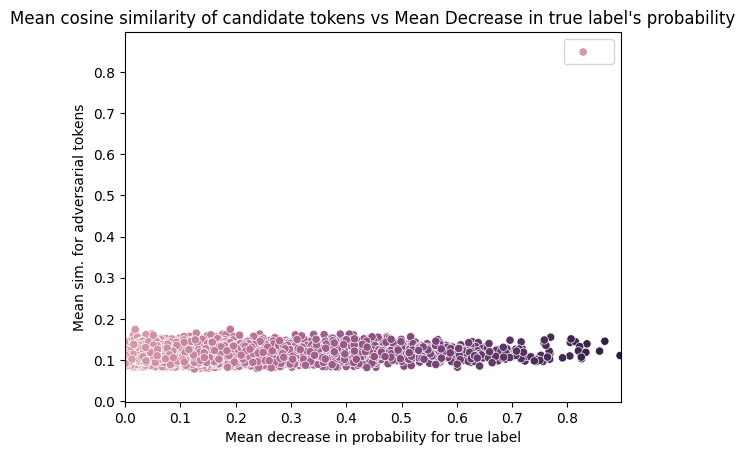

In [66]:

g = sns.scatterplot(data=df_s_mean_prob_cos_sim, x=df_s_mean_prob_cos_sim.columns[0], y=df_s_mean_prob_cos_sim.columns[1], hue=df_s_mean_prob_cos_sim.columns[0])
plt.title("Mean cosine similarity of candidate tokens vs Mean Decrease in true label's probability")
plt.legend(labels=[""])
fig = g.get_figure()
# Compute Min and Max across both and set as limits
min = df_s_mean_prob_cos_sim.min().min()
max = df_s_mean_prob_cos_sim.max().max()
#g.set_xlim(min - 0.001,max + 0.001)
g.set_xlim(0 - 0.001,max + 0.001)
g.set_ylim(0- 0.001,max+ 0.001)
plt.show()

In [67]:
max

0.8954223390288533

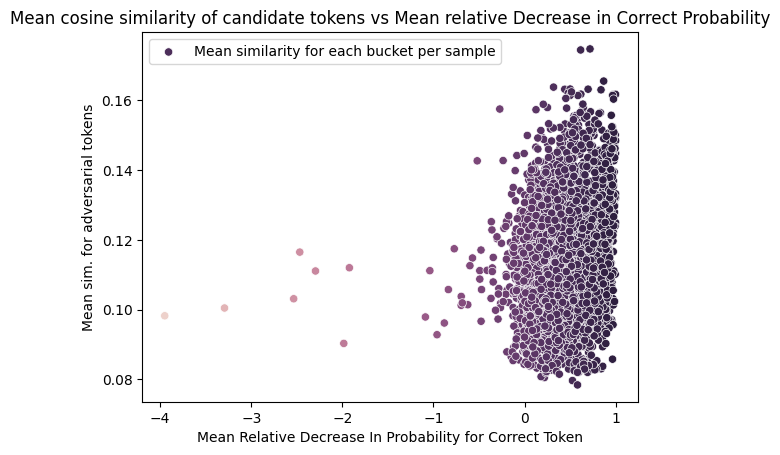

In [69]:
df_s_mean_rel_prob_cos_sim = pd.DataFrame([all_rel_mean_prob_change, all_mean_prob_cosine_sim]).T
df_s_mean_rel_prob_cos_sim.columns = ["Mean Relative Decrease In Probability for Correct Token", "Mean sim. for adversarial tokens"]
g = sns.scatterplot(data=df_s_mean_rel_prob_cos_sim, x=df_s_mean_rel_prob_cos_sim.columns[0], y=df_s_mean_rel_prob_cos_sim.columns[1], hue=df_s_mean_rel_prob_cos_sim.columns[0])
plt.title("Mean cosine similarity of candidate tokens vs Mean relative Decrease in Correct Probability")
plt.legend(labels=["Mean similarity for each bucket per sample"])
fig = g.get_figure()
# Compute Min and Max across both and set as limits
min = df_s_mean_rel_prob_cos_sim.min().min()
max = df_s_mean_rel_prob_cos_sim.max().max()
#g.set_xlim(0,1)
# g.set_ylim(0,1)
plt.show()

In [ ]:
df_s_mean_prob_cos_sim['Mean Decrease In Probability for Correct Token'].argmin()

1219

In [ ]:
df_s_mean_prob_cos_sim.iloc[1166]

Mean Decrease In Probability for Correct Token    0.320586
Mean sim. for adversarial tokens                  0.140304
Name: 1166, dtype: float64

# With filter for only lowercase words

In [8]:
all_numpy = ["/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_0_end_idx_1000_filter_only_lowercase_words.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_1000_end_idx_2000_filter_only_lowercase_words.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_2000_end_idx_3000_filter_only_lowercase_words.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_3000_end_idx_4000_filter_only_lowercase_words.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_4000_end_idx_5000_filter_only_lowercase_words.npy",

]